In [1]:
import pandas as pd
import json
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from data_cleaning import prepare_data

In [2]:
import matplotlib.font_manager as fm
from matplotlib import ft2font
from matplotlib.font_manager import ttfFontProperty

fontsize = 13
fpath = 'resources/TwitterColorEmoji-SVGinOT.ttf'
fprop = fm.FontProperties(fname=fpath)

font = ft2font.FT2Font(fpath)
fprop = fm.FontProperties(fname=fpath)

ttfFontProp = ttfFontProperty(font)


fontprop = fm.FontProperties(family='sans-serif',
                            fname=ttfFontProp.fname,
                            size=fontsize,
                            stretch=ttfFontProp.stretch,
                            style=ttfFontProp.style,
                            variant=ttfFontProp.variant,
                            weight=ttfFontProp.weight)

In [179]:
# Settings
sns.set_style("white")
sns.set_palette("Set3")

colors = ["#FA8879",
"#96C8DF",
"#BCE4CF",
"#F9E031",
"#C3D3D1"]

## Data cleaning

In [4]:
df = prepare_data("data/technokratak/")

In [5]:
df.head()

,sender_name,content,date_time,year,hour,weekday,month,reaction_Bence Pap,reaction_Péter Gulyás,reaction_Bence Ödön Blaskovich,reaction_Gábor Papp,reaction_Mate Varadi
0,Péter Gulyás,lembasz....és még egy kis lembasz!,2022-04-25 07:38:55.898,2022,7,0,202204,,,,,
1,Bence Pap,,2022-04-25 07:31:56.132,2022,7,0,202204,,,,❤,😆
2,Bence Ödön Blaskovich,május 13-15 bogát tenisz open,2022-04-15 06:50:34.236,2022,6,4,202204,,,,,
3,Gábor Papp,mate meg talan,2022-04-15 03:01:33.553,2022,3,4,202204,,,,,
4,Gábor Papp,hazaerkezo,2022-04-15 03:01:30.340,2022,3,4,202204,,,,,


In [6]:
# Save data
df.to_csv("data/technokratak/technokratak.csv", index=False)

## Analysis

In [180]:
class MessengerReport:
    def __init__(self, data, color_dict, folder_name, fontsize=13):
        self.data = data
        self.color_dict = color_dict
        self.folder_name = folder_name
        self.members = color_dict.keys()
        self.num_members = len(self.members)
        self.fontsize = fontsize
        self.reaction_columns = [
            c for c in self.data.columns if c.startswith("reaction_")
        ]

    def plot_message_volume(self, return_fig=False):
        """Show number of messages and number of words sent per member"""
        # Prepare data
        df = self.data.copy()
        df["word_count"] = df["content"].apply(lambda x: x.count(" ") + 1)
        plot_data = (
            df.groupby("sender_name")
            .agg({"hour": "count", "word_count": "sum"})
            .rename(columns={"hour": "num_message", "word_count": "total_words"})
            .sort_values("sender_name")
            .reset_index()
        )
        plot_data["colors"] = plot_data.sender_name.map(self.color_dict)
        plot_data.sort_values("num_message", inplace=True, ascending=False)

        # Prepare plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Number of messages
        sns.barplot(
            data=plot_data,
            y="sender_name",
            x="num_message",
            orient="h",
            #palette=plot_data.colors,
            saturation=1,
            ax=axes[0],
        )
        axes[0].set_xlabel("Number of messages")

        # Number of words
        plot_data.sort_values(
            "total_words", inplace=True, ascending=False, ignore_index=False
        )
        sns.barplot(
            data=plot_data,
            y="sender_name",
            x="total_words",
            orient="h",
            #palette=plot_data.colors,
            saturation=1,
            ax=axes[1],
        )
        axes[1].set_xlabel("Number of words")

        # Aesthetics
        axes[0].set_ylabel("")
        axes[1].set_ylabel("")
        plt.suptitle("Messaging volume")
        plt.tight_layout()

        if return_fig:
            return fig
        else:
            fig.savefig(f"results/{self.folder_name}/messaging_volume.png", dpi=300)

    def plot_daily_use(self, return_fig=False):
        """Show daily use of group chat per member"""
        # Prepare data
        df = self.data.copy()
        total_days = (df.date_time.max() - df.date_time.min()).days
        plot_data = (
            df.groupby(["sender_name", "hour"])["content"]
            .count()
            .reset_index()
            .rename(columns={"content": "avg_num_msg"})
        )
        plot_data["avg_num_msg"] /= total_days
        plot_data["colors"] = plot_data.sender_name.map(self.color_dict)
        plot_data = plot_data.sort_values("sender_name")

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.lineplot(
            data=plot_data,
            x="hour",
            y="avg_num_msg",
            hue="sender_name",
            #palette=list(self.color_dict.values()),
        )
        ax.set_ylabel("Avg. number of messages per day", size=13)
        ax.set_xlabel("Hour of the day", size=13)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=13)
        plt.tight_layout()

        if return_fig:
            return fig
        else:
            fig.savefig(f"results/{self.folder_name}/daily_use.png", dpi=300)

    def plot_historic_use(self, return_fig=False):
        """Show historic messaging volume"""
        # Prepare data
        df = self.data.copy()
        plot_data = (
            df.groupby(["sender_name", "month"])["content"]
            .count()
            .reset_index()
            .rename(columns={"content": "num"})
        )

        # Create plot
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.lineplot(
            data=plot_data,
            x="month",
            y="num",
            hue="sender_name",
            ax=ax,
            #palette=list(self.color_dict.values()),
        )
        ax.set_title("Messaging volume over time", size=13)
        ax.set_xlabel("Date", size=13)
        x_labels = sorted([m[0:4] + "/" + m[4:] for m in plot_data.month.unique()])
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(labels=x_labels, rotation=45)
        ax.set_ylabel("Number of messages", size=13)
        plt.legend(title="Sender")
        plt.tight_layout()

        if return_fig:
            return fig
        else:
            fig.savefig(f"results/{self.folder_name}/volume_history.png", dpi=300)

    def sample_messages_with_emoji(
        self, emoji, sample_num=None, threshold=None, print_examples=True
    ):
        """Sample messages with a minimum number of a certain emoji"""
        df = self.data.copy()
        df["num_reaction"] = df[self.reaction_columns].apply(
            lambda x: list(x).count(emoji), axis=1
        )

        if threshold is None:
            threshold = len(self.members) - 1
        if sample_num is None:
            sample_num = 2 * len(self.members)

        # Print out or return messages
        texts = []
        df_to_sample = df.loc[
            ((df["num_reaction"] >= threshold) & (df["content"] != "")),
            ["sender_name", "content"] + self.reaction_columns,
        ]
        sample = df_to_sample.sample(sample_num)
        for _, row in sample.iterrows():
            reactions_received = row[self.reaction_columns].sum()
            text = (
                row["content"]
                + "\n  sent by "
                + row["sender_name"]
                + ", received "
                + reactions_received
                + "\n\n"
            )
            if print_examples:
                print(text)
            else:
                texts.append(text)

    def plot_emoji_received(self, emoji, threshold=1, return_fig=False):
        """Find how much each member received of a certain emoji"""
        # Prepare data
        df = self.data.copy()
        df["num_emoji_reaction"] = df[self.reaction_columns].apply(
            lambda x: list(x).count(emoji), axis=1
        )
        df_filtered = df.loc[
            df["num_emoji_reaction"] >= threshold, ["sender_name", "content"]
        ]
        plot_data = (
            df_filtered.groupby("sender_name")["content"]
            .count()[self.members]
            .reset_index()
        )
        plot_data["colors"] = plot_data.sender_name.map(self.color_dict)
        plot_data.sort_values("content", ascending=False, inplace=True)

        # Create plot
        fig, ax = plt.subplots(figsize=(7, 4))
        sns.barplot(
            data=plot_data,
            y="sender_name",
            x="content",
            orient="h",
            #palette=plot_data.colors,
            saturation=1,
        )
        ax.set_xlabel(
            f"Number of messages with at least {threshold} {emoji} reactions received",
            size=self.fontsize,
        )
        ax.set_ylabel("")
        plt.tight_layout()

        if return_fig:
            return fig
        else:
            fig.savefig(
                f"results/{self.folder_name}/leaderboard_{threshold}_{emoji}.png",
                dpi=300,
            )

    def plot_reactions(self, return_fig=False):
        """Show most often sent and received reactions"""
        # Prepare data
        df = self.data.copy()

        # Create plots
        fig, axes = plt.subplots(
            self.num_members, 2, figsize=(12, 3 * self.num_members)
        )
        for i, member in enumerate(self.members):
            reactions_sent = (
                df.loc[df[f"reaction_{member}"] != "", f"reaction_{member}"]
                .value_counts()
                .reset_index()
                .rename(columns={f"reaction_{member}": "reactions"})
            )
            reactions_rec = (
                pd.Series(
                    list(
                        df.loc[df["sender_name"] == member, self.reaction_columns]
                        .sum(axis=1)
                        .sum(axis=0)
                    )
                )
                .value_counts()
                .reset_index()
                .rename(columns={0: "reactions"})
            )

            total_reaction_sent = reactions_sent["reactions"].sum()
            total_reaction_rec = reactions_rec["reactions"].sum()

            sns.barplot(
                data=reactions_rec.iloc[0:5],
                y="index",
                x="reactions",
                orient="h",
                color=self.color_dict[member],
                saturation=1,
                ax=axes[i, 0],
            )
            axes[i, 0].set_title(
                f"Most often received reactions\n(total reactions received: {total_reaction_rec})"
            )
            sns.barplot(
                data=reactions_sent.iloc[0:5],
                y="index",
                x="reactions",
                orient="h",
                color=self.color_dict[member],
                saturation=1,
                ax=axes[i, 1],
            )
            axes[i, 1].set_title(
                f"Most often sent reactions\n(total reactions sent: {total_reaction_sent})"
            )
            axes[i, 0].set_ylabel(member)
            axes[i, 1].set_ylabel("")
            axes[i, 0].set_xlabel("")
            axes[i, 1].set_xlabel("")
            fontprop = set_emoji_font()
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                axes[i, 0].set_yticklabels(
                    reactions_rec["index"][0:5],
                    size=self.fontsize * 1.5,
                    fontproperties=fontprop,
                )
                axes[i, 1].set_yticklabels(
                    reactions_sent["index"][0:5],
                    size=self.fontsize * 1.5,
                    fontproperties=fontprop,
                )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            plt.tight_layout()

        if return_fig:
            return fig
        else:
            fig.savefig(f"results/{self.folder_name}/reactions.png", dpi=300)

    def plot_reaction_network(self, emoji, return_fig=False):
        """Plot network of emoji reactions"""
        # Prepare data
        df = self.data.copy()
        # Filter dataframe to messages with selected emoji reaction
        emoji_df = df.loc[
            df[self.reaction_columns].apply(lambda x: emoji in list(x), axis=1),
            ["sender_name"] + self.reaction_columns,
        ]
        # Create matrix of reactions
        new_reaction_columns = []
        for col in self.reaction_columns:
            new_col = col.split("_")[1]
            new_reaction_columns.append(new_col)
            emoji_df[new_col] = emoji_df[col].apply(lambda x: 1 if x == emoji else 0)
            del emoji_df[col]
        reaction_matrix_df = (
            emoji_df.groupby("sender_name")[new_reaction_columns].sum().reset_index()
        )
        reaction_members = reaction_matrix_df.sender_name.tolist()
        reaction_matrix_df = reaction_matrix_df[
            ["sender_name"] + reaction_members
        ].set_index("sender_name")

        N = nx.MultiDiGraph()
        for member in reaction_members:
            m = member.replace(" ", "\n")
            N.add_node(m, color=self.color_dict[member])
        for sender in reaction_members:
            s = sender.replace(" ", "\n")
            for receiver in reaction_members:
                r = receiver.replace(" ", "\n")
                n = reaction_matrix_df[sender][receiver]
                N.add_edge(s, r, n)

        # Create graph plot
        fig, _ = plt.subplots(figsize=(12, 10))
        pos = nx.circular_layout(N)
        member_weights = [(sender, w) for sender, receiver, w in N.edges]
        reactions_sent_per_member = {
            sender.replace(" ", "\n"): w
            for sender, w in reaction_matrix_df.sum().to_dict().items()
        }
        widths = [
            w / reactions_sent_per_member[sender] * 4 for sender, w in member_weights
        ]
        nx.draw(
            N,
            with_labels=True,
            arrows=True,
            node_size=4500,
            font_size=self.fontsize,
            connectionstyle="arc3, rad = 0.1",
            width=widths,
            node_color=[self.color_dict[m.replace("\n", " ")] for m in N.nodes],
        )

        if return_fig:
            return fig
        else:
            fig.savefig(f"results/{self.folder_name}/network_of_{emoji}", dpi=300)

    def pdf_report(self, emojis=None):
        """
        Add all plots to a pdf report
        """
        # Select which emojis to analyze
        if emojis is None:
            emojis = ["😆"]

        plots = []
        # Create plots
        plots.append(self.plot_message_volume(return_fig=True))
        plots.append(self.plot_daily_use(return_fig=True))
        plots.append(self.plot_historic_use(return_fig=True))
        # self.sample_messages_with_emoji()
        plots.append(self.plot_reactions(return_fig=True))
        for emoji in emojis:
            plots.append(self.plot_emoji_received(emoji, threshold=1, return_fig=True))
            plots.append(
                self.plot_emoji_received(
                    emoji, threshold=self.num_members - 1, return_fig=True
                )
            )
            plots.append(self.plot_reaction_network(emoji, return_fig=True))

        # Create pdf
        report_pdf = PdfPages(
            f"results/{self.folder_name}/{self.folder_name}_report.pdf"
        )

        # Add title page
        fig, ax = plt.subplots(figsize=(12, 10))
        plt.text(
            0.1,
            0.5,
            f"Messenger report:\n{self.folder_name}",
            transform=fig.transFigure,
            size=self.fontsize * 2,
            fontweight="heavy",
        )
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        report_pdf.savefig(fig)

        # Add plots
        for plot in plots:
            report_pdf.savefig(plot, bbox_inches="tight", pad_inches=0.2)
        report_pdf.close()


In [181]:
members = sorted(df.sender_name.unique().tolist())
color_dict = dict(zip(members,colors))
mr = MessengerReport(data=df, 
                     color_dict=color_dict,
                     folder_name="technokratak2")

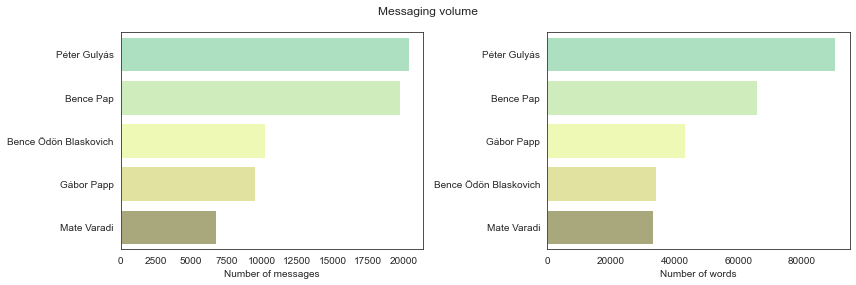

In [182]:
mr.plot_message_volume()

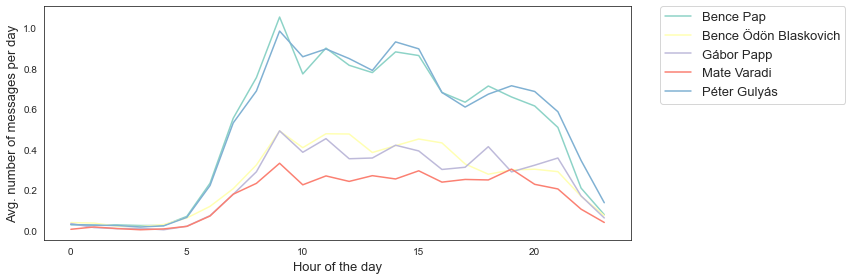

In [171]:
mr.plot_daily_use()

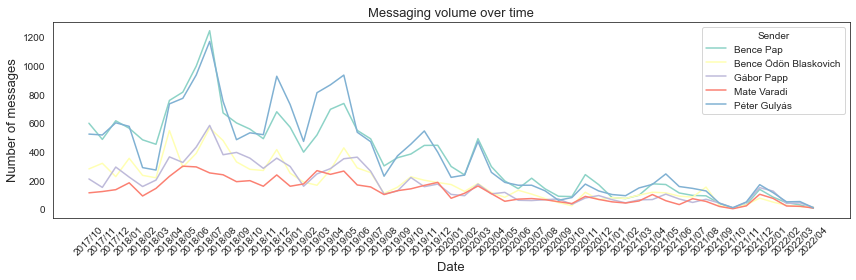

In [172]:
mr.plot_historic_use()

In [81]:
mr.sample_messages_with_emoji("😆")

nagyon jo csaj spanom, gecifull, barcsak mi is ott dolgoznank, hogy birod ki, extrafullos..
  sent by Gábor Papp, received 😆😆😆😆


feci a hazassagi ajanlatat lehet ujraszovegezne a "vinnelek az ejszakaban az ugy sima" lattan
  sent by Gábor Papp, received 😆😆😆😆


nagyon jól
  sent by Bence Pap, received 😆😆😆😆


köztük fecker is
  sent by Péter Gulyás, received 😆😆😆😆


most is ideszart valami ai
  sent by Mate Varadi, received 😆😆😆😆


csak nekem mert elkuldeni de nem akarom h lemaradjatok rola 😊
  sent by Gábor Papp, received 😆😆😆😆


adj neki egy kis aprót g
  sent by Bence Pap, received 😆😆😆😆


úgy néz ki mint a barátom a péntek balázs
  sent by Bence Ödön Blaskovich, received 😆😆😆😆


és itt biceg kicsit de ödi a mentálhigénés problémákkal küzdő feka
  sent by Péter Gulyás, received 😆😆😆😆


kér cs-vel
  sent by Bence Ödön Blaskovich, received 😆😆😆😆




In [77]:
mr.sample_messages_with_emoji("😢",threshold=3)

játszótérre is jársz meg spanom?
  sent by Bence Pap, received 😢😢😢


na papival nem tiszta nekunk h akk most mi lett 2. megszavazva paintball akk egy 😀 vagy kirándulás akk egy😢
  sent by Péter Gulyás, received 😢😆😆😢😢


nem hiszem el h az első  közös bizniszünk a gombaeladas xd
  sent by Péter Gulyás, received 😢😢😢


készen álltok?!
  sent by Péter Gulyás, received 😆😢😢😢


kivéve ha kemény drogokkal keverem
  sent by Bence Pap, received 😢😆😢😢


túl sok a társaság ezen a strandrogpályán
  sent by Bence Pap, received 😢😢😢


véletlen felcseréli a span es élvezi a drogvizsgálatot a nyelvbulin nemodán
  sent by Péter Gulyás, received 😢😢😢


máté abban a fix párom. nélküle nem adom
  sent by Bence Ödön Blaskovich, received 😢😢😢😢


csak kérdezem egyelőre h augusztus vége, akár szeptembe elejei benyúlással kinek milyen lenne
  sent by Péter Gulyás, received 😢😢😢


bungeee jumpolsz az új kihívásokba
  sent by Péter Gulyás, received 😢😢😢




/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2484812254.py:207: UserWarning: Glyph 128546 (\N{CRYING FACE}) missing from current font.
  plt.tight_layout()
/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2484812254.py:212: UserWarning: Glyph 128546 (\N{CRYING FACE}) missing from current font.
  fig.savefig(
/Users/matevaradi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128546 (\N{CRYING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


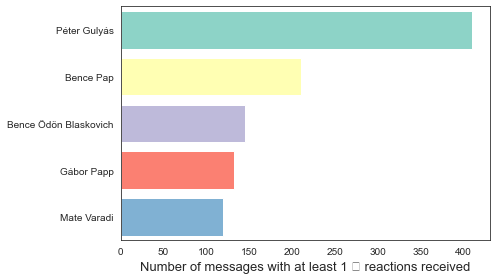

In [173]:
mr.plot_emoji_received("😢")

In [116]:
def set_emoji_font():
    fpath = "resources/TwitterColorEmoji-SVGinOT.ttf"
    font = ft2font.FT2Font(fpath)
    ttfFontProp = ttfFontProperty(font)
    fontprop = fm.FontProperties(
        family="sans-serif",
        fname=ttfFontProp.fname,
        size=20,
        stretch=ttfFontProp.stretch,
        style=ttfFontProp.style,
        variant=ttfFontProp.variant,
        weight=ttfFontProp.weight,
    )
    return fontprop

/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2484812254.py:297: UserWarning: Glyph 108 (l) missing from current font.
  fig.savefig(f"results/{self.folder_name}/reactions.png", dpi=300)
/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2484812254.py:297: UserWarning: Glyph 112 (p) missing from current font.
  fig.savefig(f"results/{self.folder_name}/reactions.png", dpi=300)
/Users/matevaradi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matevaradi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


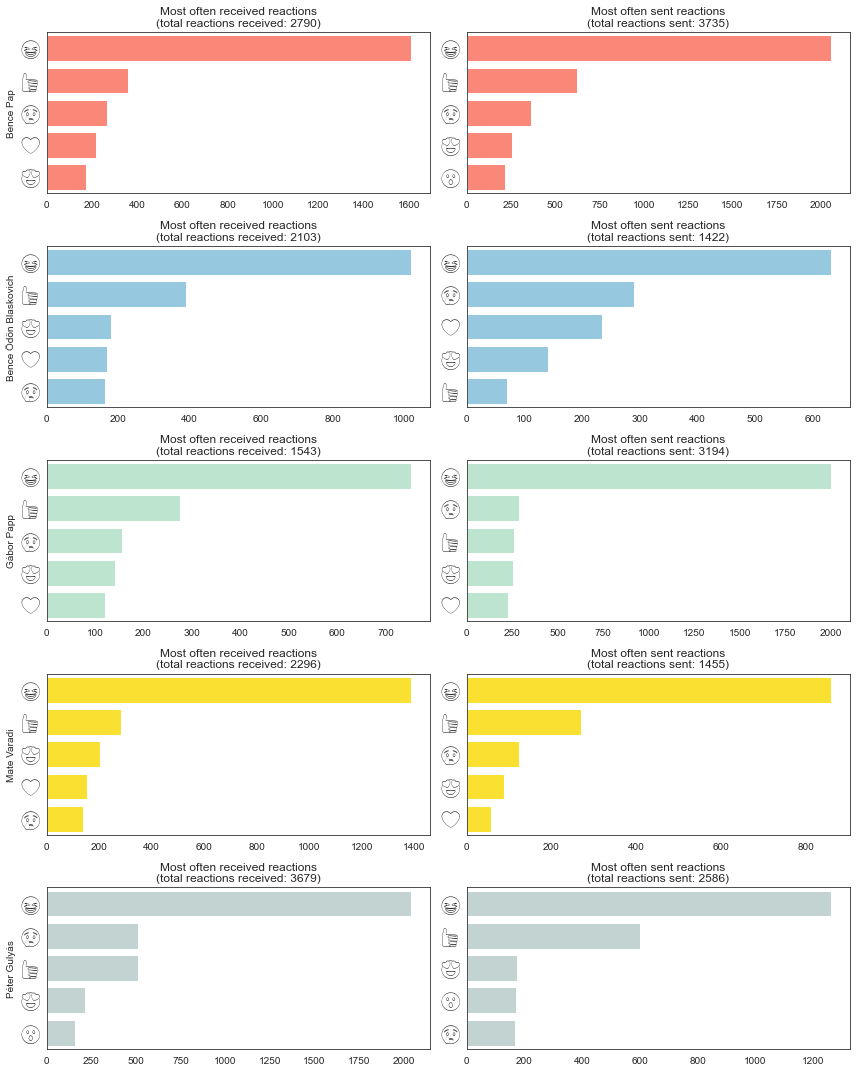

In [174]:
mr.plot_reactions()

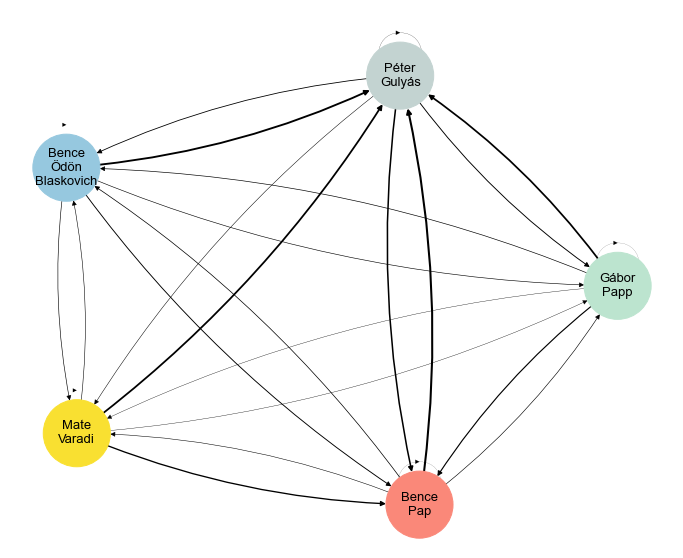

In [153]:
mr.plot_reaction_network("😢")

/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2522053089.py:207: UserWarning: Glyph 128518 (\N{SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED EYES}) missing from current font.
  plt.tight_layout()
/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2522053089.py:207: UserWarning: Glyph 128518 (\N{SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED EYES}) missing from current font.
  plt.tight_layout()
/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2522053089.py:405: UserWarning: Glyph 108 (l) missing from current font.
  report_pdf.savefig(plot, bbox_inches="tight", pad_inches=0.2)
/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2522053089.py:405: UserWarning: Glyph 112 (p) missing from current font.
  report_pdf.savefig(plot, bbox_inches="tight", pad_inches=0.2)
/var/folders/tl/3zz2r58n5kv70gmn4bcm_43w0000gn/T/ipykernel_74211/2522053089.py:405: UserWarning: Glyph 128518 (\N{SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED 

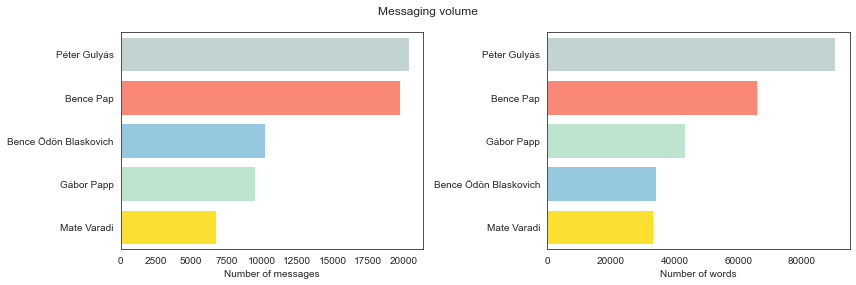

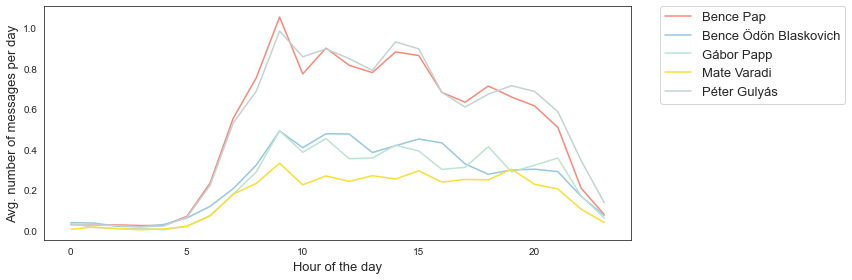

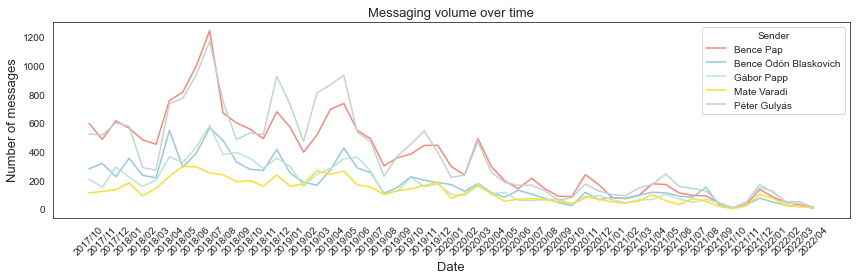

/Users/matevaradi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/matevaradi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


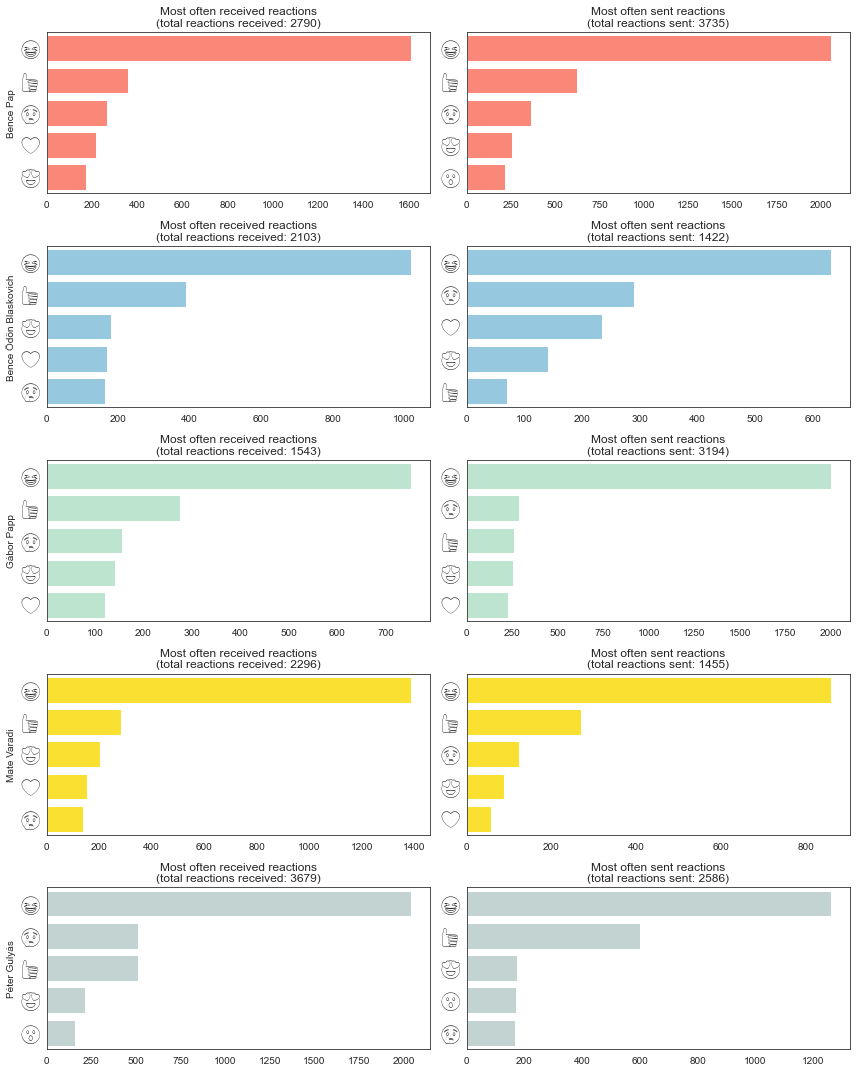

/Users/matevaradi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128518 (\N{SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED EYES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


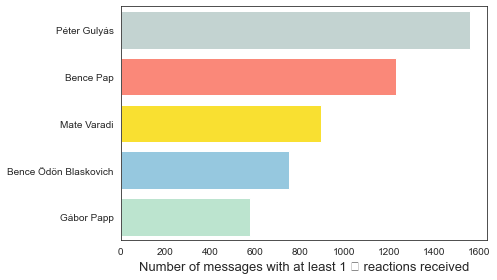

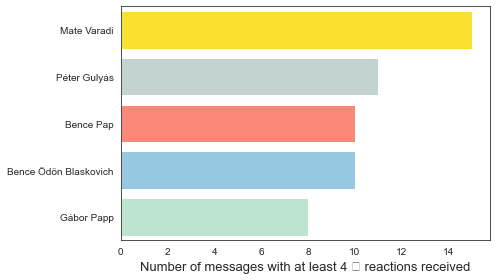

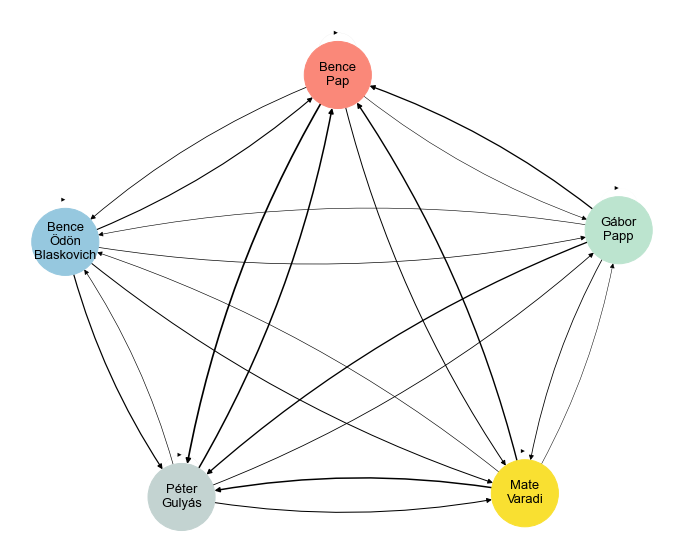

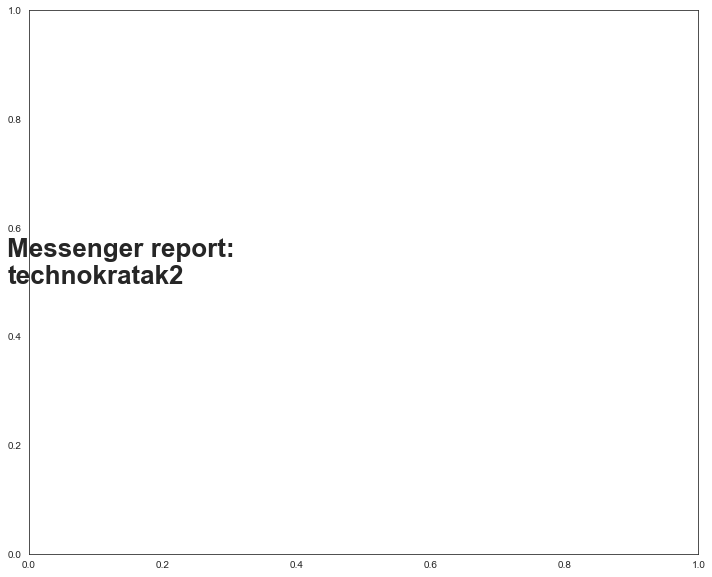

In [157]:
mr.pdf_report()

In [200]:
with PdfPages(save_loc_pdf) as pdf:
    # Title page
    self._report_title(pdf)

    # Data description
    self.data_description(pdf)

    # Model performance evaluation
    self.model_performance_eval(pdf)

    # Model interpretability plots
    self.model_interpretability_plots(pdf)

    # Model fairness evaluation
    self.model_fairness_eval(pdf)

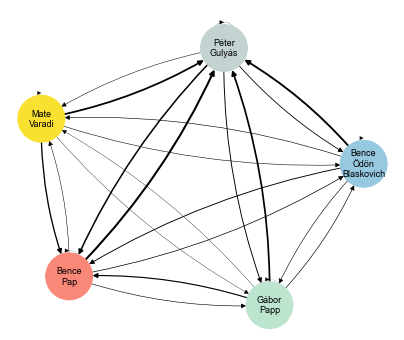

In [ ]:
# TODO
# productize (repo, pdf, .py files)

In [166]:
sns.color_palette("Set3",n_colors=10)

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353)]